# TP 4 - REDES 

In [20]:
%matplotlib inline
import numpy as np
import scipy as sp
import networkx as nx
import seaborn as sns
import pandas as pd
import os
import itertools as it
import matplotlib.pyplot as plt
from random import randint
import warnings
warnings.filterwarnings('ignore')

Cargamos los datos del archivo .csv

In [3]:
proj_dir = os.getcwd() + '/'  # Get project directory
data_filename = 'data.csv'
# Load author data (csv)
raw_data = pd.read_csv(proj_dir + data_filename,
                       sep=',',
                       header=None)

Preprocesamos los datos. Eliminamos las columnas que no son relevantes. Quitamos los campos que no son de texto

In [4]:
# Preprocess author data
prep_data = pd.DataFrame(raw_data)  # Instance for preprocessing
prep_data.drop(raw_data.columns[4:], axis=1,
               inplace=True)  # Drop unused columns
prep_data.columns = ['year', 'code',
                     'journal', 'authors']  # Rename columns


# Keep only rows where authors type is string
prep_data = prep_data[prep_data['authors'].apply(type) == str]

Para cada campo, separamos los diferentes autores y los guardamos en dos variables(autores y autores por publicación).

In [5]:
author_list = list()
authors_by_pub = list() # Authors grouped by publication

for authors in prep_data['authors']:
    curr_authors = authors.replace(' ', '')  # Remove all whitespaces
    curr_authors = curr_authors.split('&')  # Use '&' to split authors

    author_list.extend(curr_authors)
    authors_by_pub.append(curr_authors)

author_list.sort(key=str.lower)  # Sort abc based on lower case
author_list.count(author_list)  # Count author repetitions

# List of unique author names
author_set = list(set(author_list))
author_set.sort(key=str.lower)

Definimos la matriz de adyacencia del grafo a generar

In [6]:
# Build adjacency matrix
adj_df = pd.DataFrame(columns=author_set,
                      index=author_set)  # Adjacency matrix
edges = list()
for pub in authors_by_pub:  # For each publication
    for au_pair in it.combinations(pub, r=2):  # Pair-wise combinations
        adj_df[au_pair[0]][au_pair[1]] = 1  # Set edge to 1
        adj_df[au_pair[1]][au_pair[0]] = 1
        edges.append(au_pair)  # Append pair of nodes (edge)



Creamos el grafo a partir de los nodos(autores) y los enlaces(coautorías)

In [7]:
# Create graph
graph = nx.Graph()  # create graph class instance
graph.add_nodes_from(author_set)  # Add nodes from author set
graph.add_edges_from(edges)  # Add edges from author pairs

# Report number of edges and nodes
print(graph.number_of_edges())#Número de enlaces
print(graph.number_of_nodes())#Número de nodos

5944
3328


Generamos una lista con los grados de cada nodo

In [8]:
degree = nx.degree(graph)  # Degree instance (can be turned into dict/list)
dist_degrees = list()  # Node:degree pairs
for deg in degree.items():
    dist_degrees.append(deg[1])  # list of degrees

A partir de los grados de  cada nodo graficamos el histograma correspondiente y los gráficos log/log y lin/log para analizar la dependencia de las variables

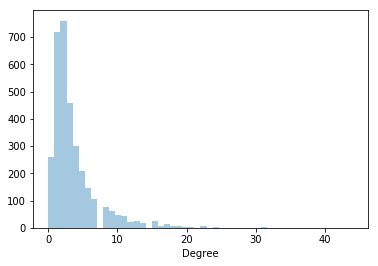

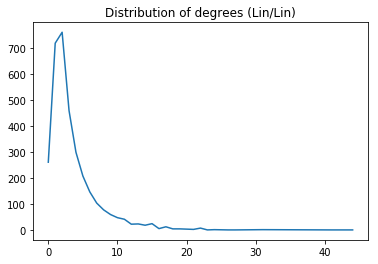

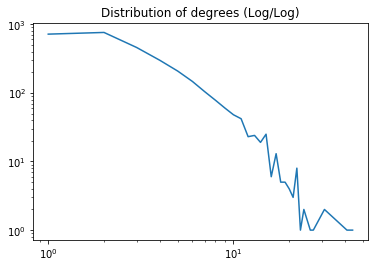

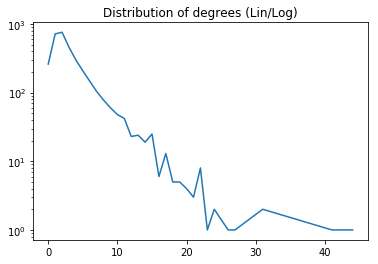

In [9]:
# Plot distribution of degrees
sns.distplot(dist_degrees, hist=True, norm_hist=False,
             kde=False, axlabel='Degree')
# Compute degree count
deg_count = [dist_degrees.count(i) for i in list(set(dist_degrees))]

plt.figure()
ax0 = plt.plot(list(set(dist_degrees)), deg_count)
plt.title('Distribution of degrees (Lin/Lin)')
plt.figure()
ax1 = plt.loglog(list(set(dist_degrees)), deg_count)
plt.title('Distribution of degrees (Log/Log)')
plt.figure()
ax2 = plt.semilogy(list(set(dist_degrees)), deg_count)
plt.title('Distribution of degrees (Lin/Log)')

Según los gráficos ploteados, podemos estimar que al graficar  la distribución en escala logarítmica (en ambos ejes), la función pareciera aproximarse a una recta. Esto indicaría que la distribución de grados tendría una forma de ley de potencias.

Analizamos las componentes del grafo y reportamos el número total de  las mismas y el número de nodos de la componenete gigante

In [10]:
# Compute connected components
conn_comp = nx.connected_component_subgraphs(graph)  # Generator object
print(len(list(conn_comp)))  # Report number of connected subcomponents
# i = 0
# for comp in conn_comp:
#     print(len(comp))
#     i += 1

# Get giant component of graph (as graph object)
giant = max(nx.connected_component_subgraphs(graph), key=len)
print(giant.number_of_nodes())  # Report size of giant component

512
2319


A partir de un nodo semilla al azar del componenete gigante, analizamos las vecindades del mismo alejándonos a 1eros vecinos, 2dos vecinos, 3eros vecinos, etc. Calculamos la cantidad de nodos totales alcanzados mediante este proceso y cuántos nodos nuevos se agregan en cada paso. Graficamos estas cantidades en función del orden de los vecinos del nodo semilla.

In [11]:
#Punto 4
lis_nodos_nuevos=list()
lis_nodos_tot=list()
maximos_nodos_nuevos=list()
nodos_nuevos_suma=list()
nodos_nuevos_suma=[0]*25
for n in range(1,11):
    nro_azar=randint(0,giant.number_of_nodes())
    nodo_semilla=giant.nodes()[nro_azar]
    lista_vecinos=list()
    lista_vecinos.append(nodo_semilla)
    vecinos_nuevos=list()
    cant_nodos_nuevos=list()
    cant_nodos_tot=list()
    for iter in range(1,25):
        if len(lista_vecinos)<giant.number_of_nodes():
            for nodo_vec in lista_vecinos:
                vecinos_nuevos=vecinos_nuevos+giant.neighbors(nodo_vec)
            vecinos_nuevos=list(set(vecinos_nuevos)-set(lista_vecinos))    
            lista_vecinos=lista_vecinos + vecinos_nuevos
            cant_nodos_nuevos.append(len(vecinos_nuevos))
            cant_nodos_tot.append(len(lista_vecinos))
        else:
            cant_nodos_nuevos.append(0)
            cant_nodos_tot.append(len(lista_vecinos))
    maximos_nodos_nuevos.append(max(cant_nodos_nuevos))
    lis_nodos_tot.append(cant_nodos_tot)
    lis_nodos_nuevos.append(cant_nodos_nuevos)
    for i in range(len(cant_nodos_nuevos)):
        nodos_nuevos_suma[i+1]=(cant_nodos_nuevos[i]+nodos_nuevos_suma[i+1])    
    
print(np.mean(maximos_nodos_nuevos))#Media del màximo
print(np.std(maximos_nodos_nuevos))#desviaciòn del màximo



722.5
27.7929847264


Vemos que la media de máximos aumentos es aproximadamente 725 con un desvío standard aproximado de 35. Podemos estimar el máximo de este valor como la media mas dos desvíos... aproximadamente el máximo valor posible de nuevos nodos agregados por paso = 800

Graficamos la cantidad de nodos nuevos agregados en cada paso que nos alejamos del nodo semilla y la cantidad total de nodos. Repetimos este proceso para 10 valores distintos al azar de nodos semillas. Observamos un comportamiento similar en estas cantidades.

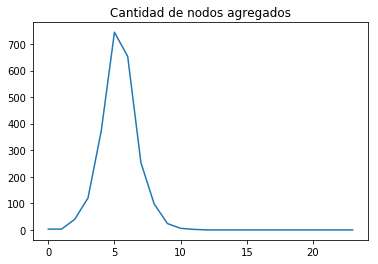

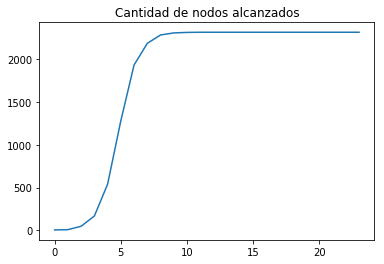

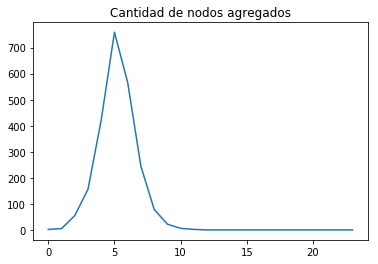

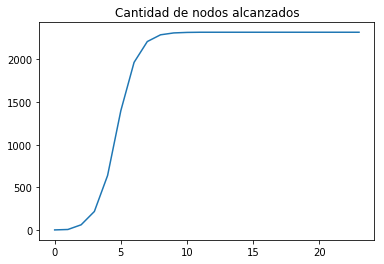

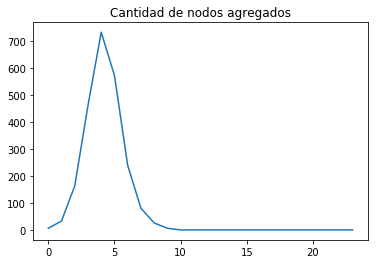

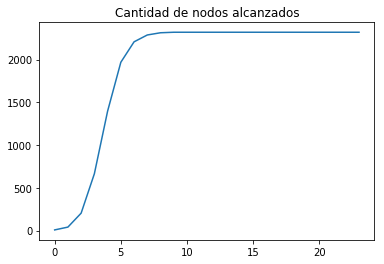

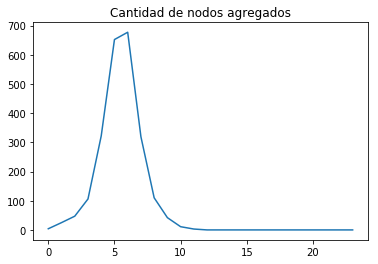

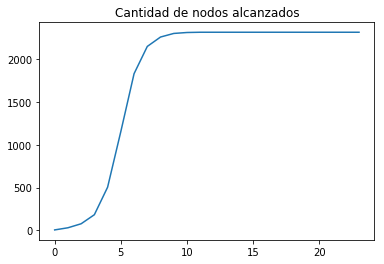

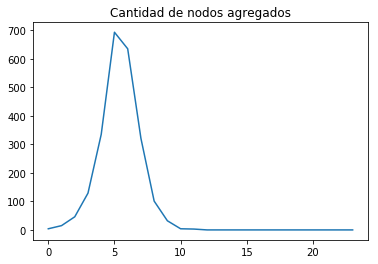

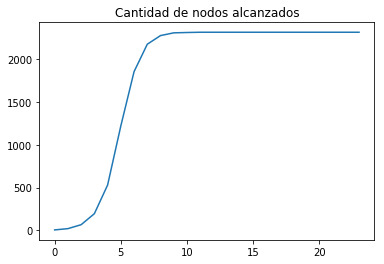

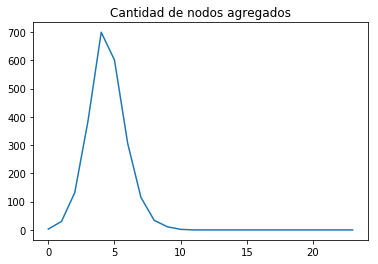

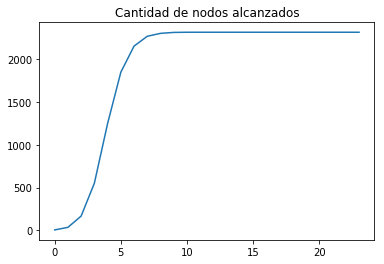

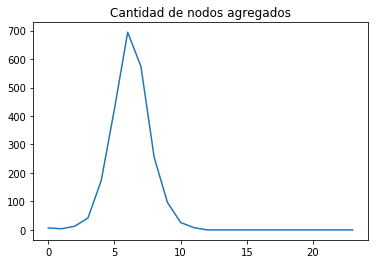

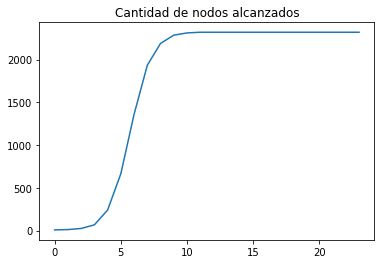

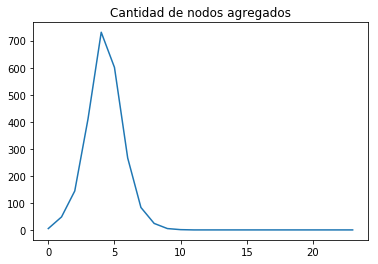

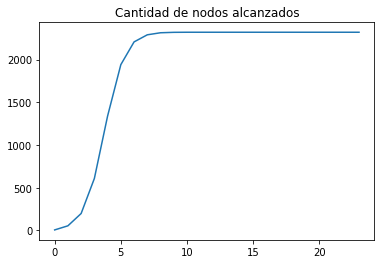

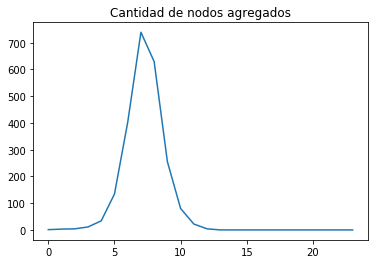

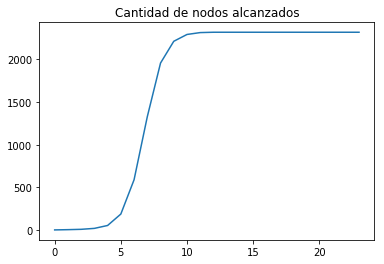

In [12]:
for i in range(1,10):
    plt.figure()
    ax0 = plt.plot(lis_nodos_nuevos[i])
    plt.title('Cantidad de nodos agregados')
    plt.figure()
    ax0 = plt.plot(lis_nodos_tot[i])
    plt.title('Cantidad de nodos alcanzados')



Calculamos la suma de los nodos agregados por paso de todas las semillas utilizdas para analizar en qué paso se produce el máximo. Puede observarse que el mismo se da, en promedio, en el paso 6. Es decir, en promedio, los nodos de la componente gigante están a seis enlaces de otro nodo al azar. Esto resulta anàlogo a los seis grados de separación hallado por el experimento de Milgram.

[0, 37, 175, 665, 1880, 4044, 5822, 5195, 3154, 1493, 520, 145, 44, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


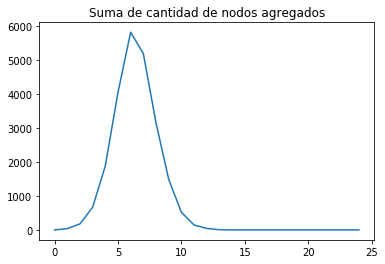

In [13]:
print(nodos_nuevos_suma) # 
plt.figure()
ax0 = plt.plot(nodos_nuevos_suma)
plt.title('Suma de cantidad de nodos agregados')

Calculamos distintas métricas sobre el componenete gigante del grafo(grado, clusteing, mean_shortest_path_length)

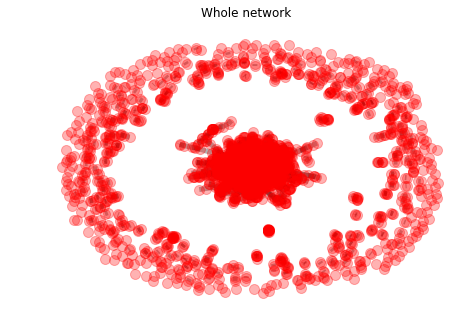

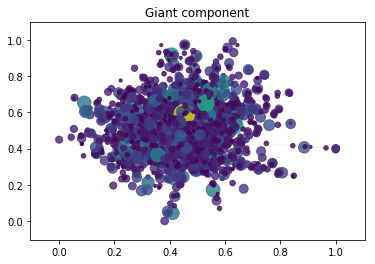

In [21]:
#Punto 5

# Degrees of giant component
degr_giant = list(dict(nx.degree(giant)).values())  # list of degrees

# Draw
plt.figure()
nx.draw(graph, with_labels=False,
        node_size=100, alpha=0.3, width=5)  # Draw whole network
plt.title('Whole network')

plt.figure()
nx.draw_networkx(giant, with_labels=False, alpha=0.8,  # Draw giant component
                 width=0.1, edge_color='gray',
                 node_size=[10*i for i in degr_giant],  # re-scale sizes
                 node_color=degr_giant, cmap='viridis')
plt.title('Giant component')

# Clustering coefficient for giant component
clustering_giant = list(nx.clustering(giant).values())  # list; cl coeff

# Average clustering coefficient
avg_clust = nx.average_clustering(giant)
# Average shortest path length
avg_shortest_plength = nx.average_shortest_path_length(giant)


En la celda anterior graficamos el grafo completo y la componenete gigante del mismo. En el primero, los nodos mas grandes y oscuros representan mayor degree. En el segundo, se utilizaron tamanos de nodos y la escala 'viridis' (violetas hacia amarillos, pasando por verdes) para representar el degree. Se adjuntan las figuras en png para una mejor visualización.

Generamos un grafo tipo random que cumpla con la condición de tener la misma distribución de grado del grafo analizado. Luego calculamos y comparamos el coeficiente de clustering y el shortest path length entre ese grafo y el de las coautorías.
Vemos que el coeficiente de clustering es bajo, mientras que el shortest path length es alto, lo cual es consistente con una small world network. Sin embargo, existen diferencias entre las metricas de la red empirica y la aleatoria, lo cual sugiere que una estadistica entre los valores de la primera y una distribucion proveniente de redes aleatorias seria adecuada para entender mejor las propiedades de interés.

In [22]:
# Generate random graph based on given degree sequence
rnd_graph = nx.random_degree_sequence_graph(degr_giant,
                                            seed=None, tries=10)
# Get giant component of random graph
conn_comp_rnd = nx.connected_component_subgraphs(rnd_graph)
rnd_giant = max(nx.connected_component_subgraphs(rnd_graph), key=len)
# Analyze clustering and shortest path length for giant of random graph
avg_clust_rnd = nx.average_clustering(rnd_giant)
avg_short_plength_rnd = nx.average_shortest_path_length(rnd_giant)
# Report measures for each network
print('AUTHOR NETWORK (giant comp):')
print('Clustering coefficient: ' + str(avg_clust))
print('Shortest path length: ' + str(avg_shortest_plength))
print('RANDOM NETWORK (giant comp):')
print('Clustering coefficient: ' + str(avg_clust_rnd))
print('Shortest path length: ' + str(avg_short_plength_rnd))

AUTHOR NETWORK (giant comp):
Clustering coefficient: 0.4929104049177371
Shortest path length: 6.253787130435041
RANDOM NETWORK (giant comp):
Clustering coefficient: 0.005138391766706406
Shortest path length: 4.852533366473849


Calculamos diferentes medidas de centralidad para los nodos del componente gigante del grafo de coautorías. Mostramos que el nodo con mayor centralidad  es el mismo al utilizar closeness centrality que betweness centrality.

In [23]:
# Compute measures of centrality

btw_giant = nx.betweenness_centrality(giant)  # Dict; betweenness
# Get author with maximum betweenness centrality
au_max_btw = max(btw_giant, key=btw_giant.get)
print('Max betweenness:', au_max_btw, btw_giant[au_max_btw])

close_giant = nx.closeness_centrality(giant)  # Dict; closeness
# Get author with maximum closeness centrality
au_max_close = max(close_giant, key=close_giant.get)
print('Max Closeness:', au_max_close, close_giant[au_max_close])

Max betweenness: Lee 0.0968809565135408
Max Closeness: Lee 0.2356888662938485


In [24]:
# take second element for sort
def takeSecond(elem):
    return elem[1]

Usamos el betweness centrality y el degree para caracterizar la centralidad de los nodos. Estos criterios de centralidad resultan apropiados y complementarios para medir a los autores "estrellas". Mientras que el degree está mididendo la cantidad de publicaciones de un dado autor, el betweness mide qué autores colaboran con diferentes comunidades de autores en principio más desconectadas, haciendo de nexo entre ellos. Por estos motivos creemos que las medidas de centralidad utilizadas resultan complementarias para medir la importancia de dichos autores.

Mostramos los 20 nodos con mayor centralidad para ambos criterios.
Luego analizamos cómo se modifica la cantidad de nodos del componente gigante a medida que se van elimnando los nodos de mayor centralidad.
Se ve que la cantidad de nodos de dicho componente cae linealmente hasta aproximadamente los 400 nodos eliminados

[9, 3, 1, 6, 3, 2, 3, 10, 2, 4, 1, 13, 8, 4, 3, 3, 2, 1, 17]


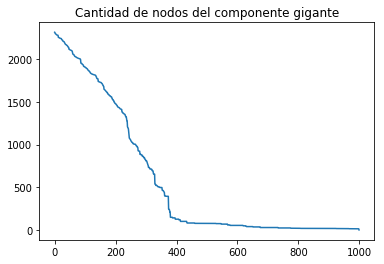

In [25]:
#Uso degree de cada nodo y betwennes centrality para cuantificar importancia de un autor
degr_giant_2=nx.degree(giant)

degr_giant_sorted=sorted(degr_giant_2.items(), key=takeSecond, reverse=True)
print(degr_giant[1:20])#20 autores mas importantes
btw_giant_sorted=sorted(btw_giant.items(), key=takeSecond, reverse=True)
btw_giant_sorted[1:20]#20 autores mas importantes
#Voy eliminando autores mas importantes y veo cuando se parte en dos la componenete gigante
giant = max(nx.connected_component_subgraphs(graph), key=len)
tam_comp_giant=[0]*1000
for i in range (1,1000):
    giant.remove_node(degr_giant_sorted[i][0])
    sub_giant = max(nx.connected_component_subgraphs(giant), key=len)
    tam_comp_giant[i-1]=sub_giant.number_of_nodes()  # Report size of giant component
plt.figure()
ax0 = plt.plot(tam_comp_giant)
plt.title('Cantidad de nodos del componente gigante')
